#### Setup Notebook

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Predicting Price Movements of Cryptocurrencies - Using Convolutional Neural Networks to Classify 2D Images of Chart Data

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

# For downloading files
from IPython.display import FileLink, FileLinks

# For confusion matrix
from sklearn.metrics import confusion_matrix

In [3]:
PATH = 'data/btc/btcgraphs_cropped/'
!ls {PATH}

test  train  valid


In [4]:
os.listdir(f'{PATH}train')

['DOWN', 'UP']

In [5]:
files = os.listdir(f'{PATH}train/DOWN')[:5]
files

['dca6474e-7a37-4d93-b604-8d16762e08c8.png',
 '78f89f2e-a236-4584-9afe-a490b7dbcbbd.png',
 '3069900a-f296-4757-bc03-765c5b53573d.png',
 '0a759740-199a-4c29-aa1b-96c6a8e72bae.png',
 'd157382e-a49b-42e8-8ffe-57aae89a196f.png']

data/btc/btcgraphs_cropped/train/DOWN/dca6474e-7a37-4d93-b604-8d16762e08c8.png
data/btc/btcgraphs_cropped/train/DOWN/78f89f2e-a236-4584-9afe-a490b7dbcbbd.png


/home/liam/crypto-project/fast-crypto-ai/data/btc/btcgraphs_cropped/train/DOWN/0a759740-199a-4c29-aa1b-96c6a8e72bae.png

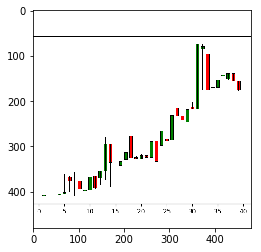

In [6]:
img = plt.imread(f'{PATH}train/DOWN/{files[3]}')
print(f'{PATH}train/DOWN/{files[0]}')
print(f'{PATH}train/DOWN/{files[1]}')
plt.imshow(img)
FileLink(f'{PATH}train/DOWN/{files[3]}')

# The Steps to Follow
1. Enable data augmentation, and precompute=True
1. Use `lr_find()` to find highest learning rate where loss is still clearly improving
1. Train last layer from precomputed activations for 1-2 epochs
1. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
1. Unfreeze all layers
1. Set earlier layers to 3x-10x lower learning rate than next higher layer
1. Use `lr_find()` again
1. Train full network with cycle_mult=2 until over-fitting

## 0. Setup

In [10]:
arch = resnet34
sz = 480
batch_size = int(64)

## 1. Data Augmentation
**Not using data augmentation this time**

Starting without useing data augmentation because I don't think it makes sense for these graphs, we don't need to generalize to slightly different angles. All plots will always be straight on and square in the frame.

In [11]:
tfms = tfms_from_model(arch, sz)

In [12]:
data = ImageClassifierData.from_paths(PATH, bs=batch_size, tfms=tfms, 
                                      trn_name='train', val_name='valid')#, test_name='test')

## 2. Choose a Learning Rate

In [ ]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

 11%|█▏        | 830/7263 [21:22<2:45:42,  1.55s/it]

In [ ]:
learn.save('00_pretrained_480')

In [ ]:
# learn.precompute = True
learn.load('00_pretrained_480')

In [ ]:
lrf = learn.lr_find()

In [ ]:
learn.sched.plot_lr()

In [ ]:
learn.sched.plot()

In [ ]:
learn.save('01_lr_found_480')

## 3. Train Last Layer

In [ ]:
# learn.precompute = True
learn.load('01_lr_found_480')

In [ ]:
learn.fit(1e-4, 1)

In [ ]:
learn.save("02_trained_once_480")

#### Accuracy

TODO

Do some tests on accuracy of training on single epoch

## 4. Train Last Layer with Data Augmentation
**Didn't think this is appropriate**

In [ ]:
# learn.precompute = True
learn.load("02_trained_once_480")

In [ ]:
learn.precompute=False

In [ ]:
learn.fit(1e-4, 3, cycle_len=1)

In [ ]:
learn.save("03_trained_2x_480")

In [ ]:
learn.load("trained_2_market_movement")

More accuracy test...

In [ ]:
learn.unfreeze()

Using a relatively large learning rate to train the prvious layers because this data set is not very similar to ImageNet

In [ ]:
lr = np.array([0.0001/9, 0.0001/3, 0.00001])

In [ ]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2, best_save_name = "best_model")

In [ ]:
learn.save("trained_3_market_movement")

In [ ]:
learn.load("trained_3_market_movement")

# Look at Results

In [ ]:
data.val_y

In [ ]:
data.classes

In [ ]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

In [ ]:
log_preds[:10]

In [ ]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)
probs

In [ ]:
probs[1]

In [ ]:
def rand_by_mask(mask): 
    return np.random.choice(np.where(mask)[0], 4, replace=False)

def rand_by_correct(is_correct): 
    return rand_by_mask((preds == data.val_y)==is_correct)
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])
def load_img_id(ds, idx): 
    return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

In [ ]:
plot_val_with_title(rand_by_correct(True), "Correctly classified")

In [ ]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

In [ ]:
plot_val_with_title(most_by_correct(0, True), "Most correct DOWN")

In [ ]:
plot_val_with_title(most_by_correct(1, True), "Most correct UP")

In [ ]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect DOWN")

# Analyze Results

In [ ]:
data.val_y
log_preds = learn.predict()
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(data.val_y, preds)

In [ ]:
plot_confusion_matrix(cm, data.classes)

In [ ]:
cm

In [ ]:
(cm[0][0]+cm[1][1])/(np.sum(cm))

In [ ]:
np.sum(cm)-(42313)